In [3]:
import warnings
warnings.filterwarnings("ignore")
from shapely import wkt
import glob


%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import skimage

from tqdm import tqdm
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

from catalyst.contrib.criterion import FocalLossMultiClass, DiceLoss, BCEDiceLoss, LovaszLossBinary,LovaszLossMultiClass

from importlib import reload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [4]:
def to_onehot(indices, num_classes):
    """Convert a tensor of indices of any shape `(N, ...)` to a
    tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
    input's device`.
    """
    onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
#                              dtype=torch.uint8,
                         device=indices.device)
    return onehot.scatter_(1, indices.unsqueeze(1), 1)
class CombinedLoss(nn.Module):

    def __init__(self, gamma=2., alpha=0.25):
        super(CombinedLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target):
        y = to_onehot(target, input.size(-1))
        logit = F.softmax(input)
                     
        focal_loss = FocalLossMultiClass(gamma=self.gamma, alpha=self.alpha)
#         bce_dice = BCEDiceLoss()
#         lovaz_loss = LovaszLossBinary()
#         dice_loss = DiceLoss(activation='Softmax')
        
        total_loss = focal_loss(logit, target) #+ 0.2 * dice_loss(logit, y)
        return total_loss

In [16]:
data_dir = Path("/media/wwymak/Storage/xView2")
models_path = data_dir / "models"
classifcation_crop_dir = data_dir/"classification_crops"
classification_labels = pd.read_csv(data_dir/"train.csv")

damage_crops_test_folder = data_dir / "classification_crops_test"

In [6]:
classification_labels.head()

,uuid,img_id,label,crop_filename
0,c18d34cd-d48d-43ba-9d9c-011b6f9d5eb8,palu-tsunami_00000024_post_disaster.png,0,c18d34cd-d48d-43ba-9d9c-011b6f9d5eb8.png
1,4db83f7b-7c77-4cb4-8ea7-ad5a338a92b1,palu-tsunami_00000024_post_disaster.png,0,4db83f7b-7c77-4cb4-8ea7-ad5a338a92b1.png
2,fc34426b-db11-403d-bdcf-1527b7d2508a,palu-tsunami_00000024_post_disaster.png,0,fc34426b-db11-403d-bdcf-1527b7d2508a.png
3,052f9f14-e32e-484a-811d-cd0fac134493,palu-tsunami_00000024_post_disaster.png,0,052f9f14-e32e-484a-811d-cd0fac134493.png
4,577576f3-3bdc-41ec-a571-6f6cf843cf3b,palu-tsunami_00000024_post_disaster.png,0,577576f3-3bdc-41ec-a571-6f6cf843cf3b.png


In [7]:
def get_train_valid_ids(classification_labels_df, valid_pct=0.1, random_seed=42):
    np.random.seed(random_seed)
    unique_img_ids = classification_labels_df.img_id.unique()
    np.random.shuffle(unique_img_ids)
    train_img_ids = unique_img_ids[:int(len(unique_img_ids) * (1- valid_pct))]
    valid_img_ids = unique_img_ids[int(len(unique_img_ids) * (1- valid_pct)):]
    
    train_ids = classification_labels_df[classification_labels_df.img_id.isin(train_img_ids)].crop_filename.values
    valid_ids = classification_labels_df[classification_labels_df.img_id.isin(valid_img_ids)].crop_filename.values
    
    return train_ids, valid_ids
    

In [9]:
train_ids, valid_ids = get_train_valid_ids(classification_labels)

In [10]:
classification_labels_resampled= pd.concat([
    classification_labels[(classification_labels.label!= 0) & (~classification_labels.crop_filename.isin(valid_ids))],
    classification_labels[(classification_labels.label==0) & (~classification_labels.crop_filename.isin(valid_ids))].sample(frac=0.2),
    classification_labels[classification_labels.crop_filename.isin(valid_ids)],
])
classification_labels_resampled.label.value_counts(normalize=True), classification_labels_resampled[(~classification_labels.crop_filename.isin(valid_ids))].label.value_counts(normalize=True), 

(0    0.445619
 1    0.196012
 2    0.185295
 3    0.173074
 Name: label, dtype: float64, 0    0.358821
 1    0.225587
 2    0.215748
 3    0.199844
 Name: label, dtype: float64)

In [12]:

def is_valid_func(img_fname):
    id = Path(img_fname).name
    return id in valid_ids


In [14]:

def f1(y_pred:Tensor, y_true:Tensor):
    eps=1e-10
    def recall(y_pred,y_true):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        possible_positives = torch.sum(y_true)
        recall = true_positives / (possible_positives + eps)
        return recall

    def precision(y_pred,y_true):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        predicted_positives = torch.sum(torch.round(torch.clamp(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives +eps)
        return precision

    y_true = to_onehot(y_true.view(-1), num_classes=4)
    precision = precision(y_pred,y_true)
    recall = recall(y_pred,y_true)
    return 2*((precision*recall)/(precision+recall+eps))#


In [19]:
size=128
bs=32
partial_data_frac=0.2
src = (ImageList
       .from_df(classification_labels_resampled, path=classifcation_crop_dir, cols=['crop_filename'])
#        .use_partial_data(partial_data_frac)
       .split_by_valid_func(is_valid_func)
       .label_from_df(cols='label'))
data = (src
        .transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=False)
        .add_test_folder(damage_crops_test_folder)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn = cnn_learner(data,models.resnet50, metrics=[accuracy, f1])
learn.model_dir = models_path
learn.loss_func =CombinedLoss();
learn.to_fp16();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


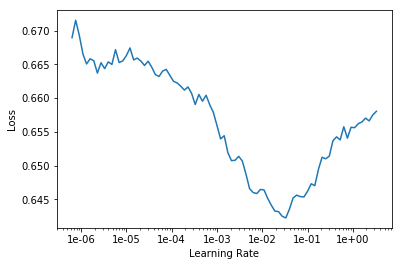

In [20]:
learn.lr_find()
learn.recorder.plot();

In [21]:
learn.fit_one_cycle(3, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.549413,0.522223,0.693084,0.640034,08:49
1,0.525035,0.497734,0.750861,0.698931,02:13
2,0.510372,0.493710,0.762737,0.692531,02:13


In [23]:
for size, bs  in zip([32, 64, 256], [64, 32, 16]):
    data = (src
        .transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=False)
        .add_test_folder(damage_crops_test_folder)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

    learn = cnn_learner(data,models.resnet50, metrics=[accuracy, f1])
    learn.model_dir = models_path
    learn.loss_func =CombinedLoss();
    learn.to_fp16();

    learn.fit_one_cycle(3, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.575277,0.542138,0.612540,0.590187,01:01
1,0.552976,0.536487,0.635614,0.619574,01:02
2,0.548813,0.526791,0.660965,0.648325,01:00


epoch,train_loss,valid_loss,accuracy,f1,time
0,0.558542,0.528329,0.669333,0.640407,01:58
1,0.532568,0.514290,0.697330,0.677492,01:59
2,0.526206,0.499071,0.742739,0.706594,01:57


epoch,train_loss,valid_loss,accuracy,f1,time
0,0.555212,0.507766,0.728464,0.661637,05:13
1,0.529828,0.493308,0.760829,0.710648,05:15
2,0.518561,0.489015,0.770797,0.721736,05:16


In [24]:
bs=16
size=256
src = (ImageList
       .from_df(classification_labels, path=classifcation_crop_dir, cols=['crop_filename'])
#        .use_partial_data(partial_data_frac)
       .split_by_valid_func(is_valid_func)
       .label_from_df(cols='label'))
data = (src
    .transform(get_transforms(do_flip=True, 
         flip_vert=True, 
         max_rotate=180, 
         max_zoom=1.2, 
         max_lighting=0.5,
         max_warp=0.2, 
         p_affine=0.75, 
         p_lighting=0.75), size=size, tfm_y=False)
    .add_test_folder(damage_crops_test_folder)
    .databunch(bs=bs)
    .normalize(imagenet_stats))

learn = cnn_learner(data,models.resnet50, metrics=[accuracy, f1])
learn.model_dir = models_path
learn.loss_func =CombinedLoss();
learn.to_fp16();

learn.fit_one_cycle(3, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.489683,0.478874,0.802917,0.786711,18:07
1,0.464868,0.467234,0.828329,0.765778,12:21
2,0.468766,0.462331,0.837743,0.758084,12:23


In [25]:
bs=32
size=64
src = (ImageList
       .from_df(classification_labels, path=classifcation_crop_dir, cols=['crop_filename'])
#        .use_partial_data(partial_data_frac)
       .split_by_valid_func(is_valid_func)
       .label_from_df(cols='label'))
data = (src
    .transform(get_transforms(do_flip=True, 
         flip_vert=True, 
         max_rotate=180, 
         max_zoom=1.2, 
         max_lighting=0.5,
         max_warp=0.2, 
         p_affine=0.75, 
         p_lighting=0.75), size=size, tfm_y=False)
    .add_test_folder(damage_crops_test_folder)
    .databunch(bs=bs)
    .normalize(imagenet_stats))

learn = cnn_learner(data,models.resnet50, metrics=[accuracy, f1])
learn.model_dir = models_path
learn.loss_func =CombinedLoss(alpha=0.5);
learn.to_fp16();

learn.fit_one_cycle(3, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.354431,0.344200,0.782550,0.780387,04:41
1,0.341936,0.337134,0.799409,0.792808,04:54
2,0.341049,0.334339,0.806731,0.779855,04:49


In [26]:
learn = cnn_learner(data,models.resnet50, metrics=[accuracy, f1])
learn.model_dir = models_path
learn.loss_func =CombinedLoss(alpha=0.75);
learn.to_fp16();

learn.fit_one_cycle(3, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.203568,0.199717,0.781935,0.772309,04:47
1,0.199527,0.194640,0.801748,0.784001,04:48
2,0.196045,0.193236,0.805501,0.799205,04:49


In [27]:
learn = cnn_learner(data,models.resnet50, metrics=[accuracy, f1])
learn.model_dir = models_path
learn.loss_func =CombinedLoss(alpha=0.85);
learn.to_fp16();

learn.fit_one_cycle(3, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.146361,0.140073,0.792641,0.787271,04:49
1,0.141474,0.138691,0.797440,0.786773,04:45
2,0.142663,0.137542,0.801748,0.791829,04:38


In [ ]:
learn = cnn_learner(data,models.resnet50, metrics=[accuracy, f1])
learn.model_dir = models_path
learn.loss_func =CombinedLoss(alpha=0.75, gamma=4);
learn.to_fp16();

learn.fit_one_cycle(3, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.053068,0.051000,0.815900,0.804071,04:38
